# Path To CSV Files
- path1 is to year of transactions
- path2 is to week of transactions

In [32]:
path1 = 'trans2017.csv'
path2 = 'trans5.26.csv'

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table

In [34]:
from re import sub
from decimal import Decimal
import datetime
from decimal import Decimal, ROUND_HALF_UP
from dateutil.parser import parse

#special dictionary to correspond numbers to days of week
days_key = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

#returns HH:MM:SS as numbers in list
def format_time(t):
    tm = t.split(':')
    tm = list(map(int, tm))
    return tm

#returns numeric version of cash value
def format_money(m):
    return Decimal(sub(r'[^\d.]', '', m))

#given a date in mm/dd/yy returns string of day of week
def day_of_week(dt):
    date = dt.split('/')
    date[2] = '20' + date[2]
    date = list(map(int, date))
    #return days_key[datetime.datetime(date[2], date[0], date[1]).weekday()] 
    return datetime.datetime(date[2], date[0], date[1]).weekday()

#rounds decimal to two places for dollars
def round_decimal(x):
    return x.quantize(Decimal(".01"), rounding=ROUND_HALF_UP)

#output a dataframe that is easy to work with from transactions raw data
def process_transactions(path):
    #cleaning
    td = pd.read_csv(path, low_memory=False) #load
    td = td[['Date', 'Time', 'Gross Sales']].copy() #use only relevant fields
    td.insert(2, 'Day', td['Date'].apply(lambda x : day_of_week(x))) #add column for day of week
    td['Time'] = td['Time'].apply(lambda x : format_time(x)[0]) #format time to hour
    td['Gross Sales'] = td['Gross Sales'].apply(lambda x : format_money(x)) #format sales at decimal
    td.drop(td[td['Gross Sales'] == 0.00].index, inplace = True) #delete gross sales of 0.00
    
    #preparing results, day_average
    times = td['Time'].unique() #unique hours
    times = times[(times>=5) & (times<=18)] #cut hours not between 5AM - 6PM
    times.sort() #accending order
    days = td['Day'].unique() #unique days in data
    days.sort()
    res = pd.DataFrame(index = times, columns = days) #resulting dataframe with unique times & days
    res.index.name = 'Hour' #label index
    day_averages = pd.DataFrame(index = ['Average Gross Sales'], columns = days)
    #workers = pd.DataFrame(index = times, columns = days)
    
    #populate results, day_averages
    for v in days:
        day = td[td['Day'] == v] #select all transactions on day, ie: Monday
        num_day = day['Date'].unique().size #number of these days, ie: Number of Mondays
        gros_tot_day = day['Gross Sales'].sum() #total gross sales for day, ie: Total Gross of all Mondays
        day_ave = gros_tot_day / num_day #average gross sales for day ie: Average gross on Mondays
        day_averages[v] = round_decimal(day_ave) #populate another data frame with whole day averages
        for t in times:
            if t in day['Time'].unique(): #some days have longer hours, check if this hour is in this day, ie: 5AM doesn't exist on Sundays
                day_hr_ave = day[day['Time'] == t]['Gross Sales'].sum() / num_day #Average sales on this hour on this day
                res[v][t] = round_decimal(day_hr_ave) #select day & hour in resulting frame and insert formated day_hr_ave
    
    res.fillna(0, inplace = True) #replace NaN with 0, these are likely times we aren't open
    res.columns = list(map(lambda x:days_key[x],res.columns))
    day_averages.columns = list(map(lambda x:days_key[x],day_averages.columns))
    '''
    for v in list(td['Date'].unique()):
        #populate works dataframe with who was working each hour of each day of the week
    '''

    return res, day_averages

#plots the charts, given two processed transactions, a day, and a show frame parameter
def plot_sales(t, tsub, d, show_frames = False, save = False):
    
    if d not in t[0].columns:
        print('{} not in transactions'.format(d))
        return
    if d not in tsub[0].columns:
        print('{} not in sub-transactions'.format(d))
        return
    #parameters t
    n_groups_t = t[0].index.size #groups correspond to hours in transactions
    indecies_t = np.arange(n_groups_t) #indecies from 0 to the value of n_groups
    groups_t = t[0].index #list of hours in subset transactions
    
    #parameters tsub
    n_groups_tsub = tsub[0].index.size #groups correspond to hours in subset transactions
    indecies_tsub = np.arange(n_groups_tsub) #indecies from 0 to the value of n_groups
    groups_tsub = tsub[0].index #list of hours in subset transactions
    
    #parameters other
    bar_width = 0.45
    
    #Comparison of t & tsub
    fig1, ax1 = plt.subplots(figsize = (18, 6))
    plt.bar(indecies_t, t[0][d].values, bar_width, color='b', label='{} of {}'.format(d, path1))
    plt.bar(indecies_tsub + bar_width, tsub[0][d].values, bar_width, color='r', label='{} of {}'.format(d, path2))
    plt.xlabel('Hours (hr)', fontsize = 14)
    plt.ylabel('Average Sales ($)', fontsize = 14)
    plt.title('Average Sales by Hour: {}'.format(d), fontsize = 18)
    plt.xticks(indecies_t + bar_width/2, groups_t)
    for i, j in zip(indecies_t, t[0][d].values):
        ax1.text(i-(bar_width/2), j+2, '$' + str(j), color='b', fontweight='bold')
    for i, j in zip(indecies_tsub, tsub[0][d].values):
        ax1.text(i + (bar_width/2), j+2, '$' + str(j), color='r', fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #Difference between t & tsub
    #parameters
    bar_width *= 0.5
    
    fig2, ax2 = plt.subplots(figsize = (18,6))
    dif = tsub[0][d] - t[0][d]
    dif_pos = dif.values.copy() 
    dif_pos[dif_pos<0] = 0
    dif_neg = dif.values.copy()
    dif_neg[dif_neg>0] = 0
    #plt.axis([0, 6, 0, 20])
    plt.bar(indecies_t, dif_pos, bar_width, color='g')
    for i, j, v in zip(indecies_t, dif_pos, t[0][d].values):
        if (j != 0):
            ax2.text(i-(bar_width/2), j+3, '$' + str(j), color='g', fontweight='bold')
            #ax2.text(i-(bar_width/2), j+3, str(round_decimal(100*j/v)) + ' %', color='g', fontweight='bold')
    plt.bar(indecies_t, dif_neg, bar_width, color='r')
    for i, j, v in zip(indecies_t, dif_neg, t[0][d].values):
        if (j != 0):
            ax2.text(i-(bar_width/2), j-3, '$' + str(j), color='r', fontweight='bold')
            #ax2.text(i-(bar_width/2), j-3, str(round_decimal(100*j/v)) + ' %', color='r', fontweight='bold')
    plt.xlabel('Hours (hr)', fontsize = 14)
    plt.ylabel('Average Sales ($)', fontsize = 14)
    plt.title('Difference Average Sales by Hour: {}'.format(d), fontsize = 18)
    plt.xticks(indecies_t, groups_t)
    plt.grid(True)
    plt.show()
    
    if show_frames:
        #Data Frames
        print('Year Average Sales by Hour')
        display(t[0])
        display(t[1])
        print('Week Average Sales by Hour')
        display(tsub[0])
        display(tsub[1])

# Charts
- Average Sales by Hour: Each hour is out of 24 and shows average sales from the two transaction files
- Difference Average Sales by Hour: Each hour shows how far off from the year average the given week was. 
- If tables are displayed, they show the data the charts are based off of. 

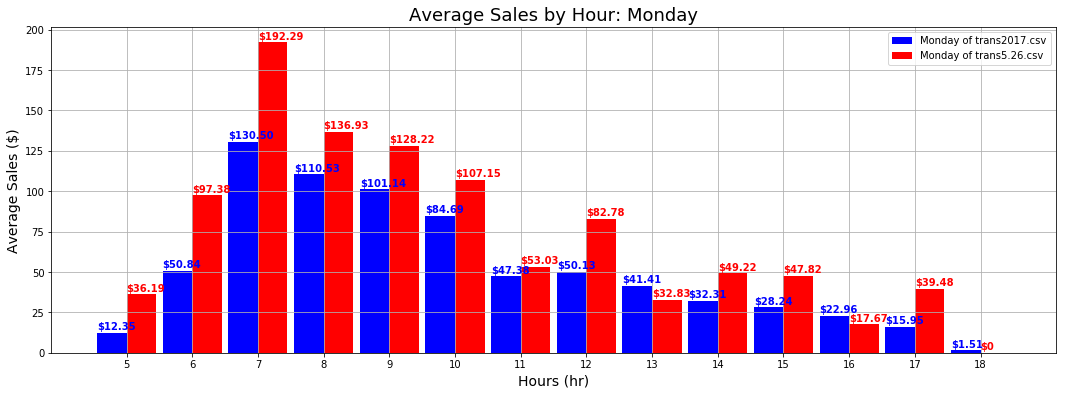

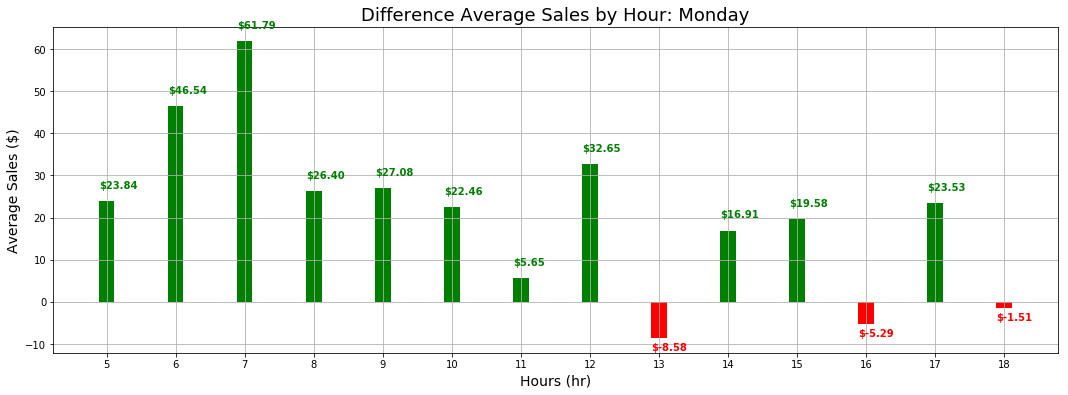

Year Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,12.35,17.47,14.09,14.84,13.93,0,0
6,50.84,63.96,61.12,61.47,62.40,0.62,0.07
7,130.50,137.34,153.05,153.65,166.23,38.76,7.19
8,110.53,120.30,123.79,121.94,139.98,73.83,44.00
9,101.14,102.09,105.84,102.81,103.69,77.80,67.21
10,84.69,92.95,94.34,92.08,106.96,85.95,77.98
11,47.38,59.26,44.75,46.85,56.89,66.30,60.89
12,50.13,54.60,53.38,54.01,52.09,53.73,42.32
13,41.41,44.11,43.27,43.77,55.44,38.72,32.33


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,730.06,808.49,801.47,809.34,884.58,522.12,378.48


Week Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,36.19,32.15,26.16,18.83,25.71,0,0
6,97.38,78.24,74.37,111.79,90.61,0,0
7,192.29,183.45,242.74,272.16,318.61,84.48,14.00
8,136.93,126.58,153.17,124.89,209.35,87.68,52.82
9,128.22,124.82,136.31,156.32,104.20,88.57,101.20
10,107.15,82.65,111.16,98.40,124.98,67.47,162.07
11,53.03,61.28,42.25,37.41,49.48,39.71,58.33
12,82.78,57.77,105.08,74.38,116.36,0,22.03
13,32.83,62.09,82.09,52.34,22.03,0,50.27


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,1020.99,1001.11,1149.96,1147.72,1061.33,367.91,525.89


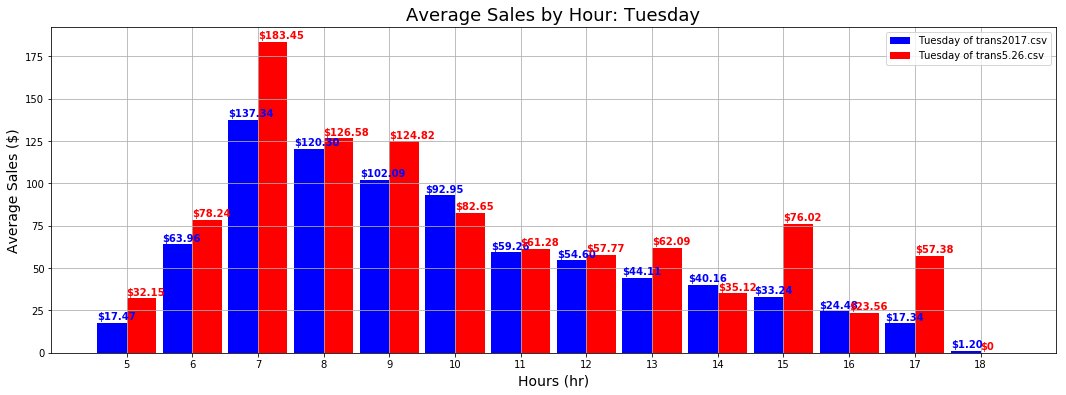

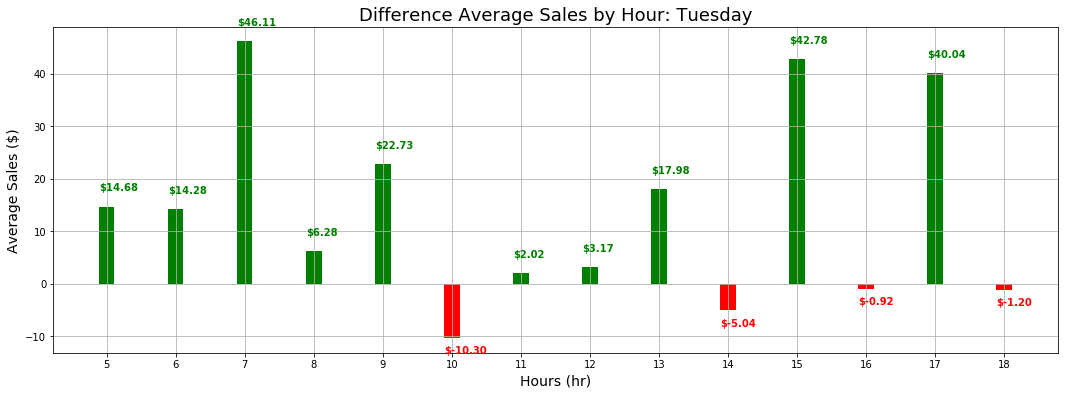

Year Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,12.35,17.47,14.09,14.84,13.93,0,0
6,50.84,63.96,61.12,61.47,62.40,0.62,0.07
7,130.50,137.34,153.05,153.65,166.23,38.76,7.19
8,110.53,120.30,123.79,121.94,139.98,73.83,44.00
9,101.14,102.09,105.84,102.81,103.69,77.80,67.21
10,84.69,92.95,94.34,92.08,106.96,85.95,77.98
11,47.38,59.26,44.75,46.85,56.89,66.30,60.89
12,50.13,54.60,53.38,54.01,52.09,53.73,42.32
13,41.41,44.11,43.27,43.77,55.44,38.72,32.33


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,730.06,808.49,801.47,809.34,884.58,522.12,378.48


Week Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,36.19,32.15,26.16,18.83,25.71,0,0
6,97.38,78.24,74.37,111.79,90.61,0,0
7,192.29,183.45,242.74,272.16,318.61,84.48,14.00
8,136.93,126.58,153.17,124.89,209.35,87.68,52.82
9,128.22,124.82,136.31,156.32,104.20,88.57,101.20
10,107.15,82.65,111.16,98.40,124.98,67.47,162.07
11,53.03,61.28,42.25,37.41,49.48,39.71,58.33
12,82.78,57.77,105.08,74.38,116.36,0,22.03
13,32.83,62.09,82.09,52.34,22.03,0,50.27


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,1020.99,1001.11,1149.96,1147.72,1061.33,367.91,525.89


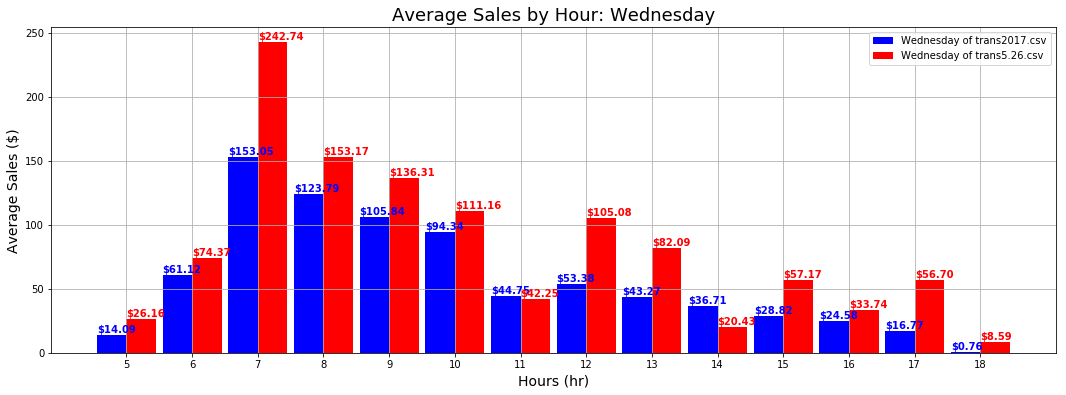

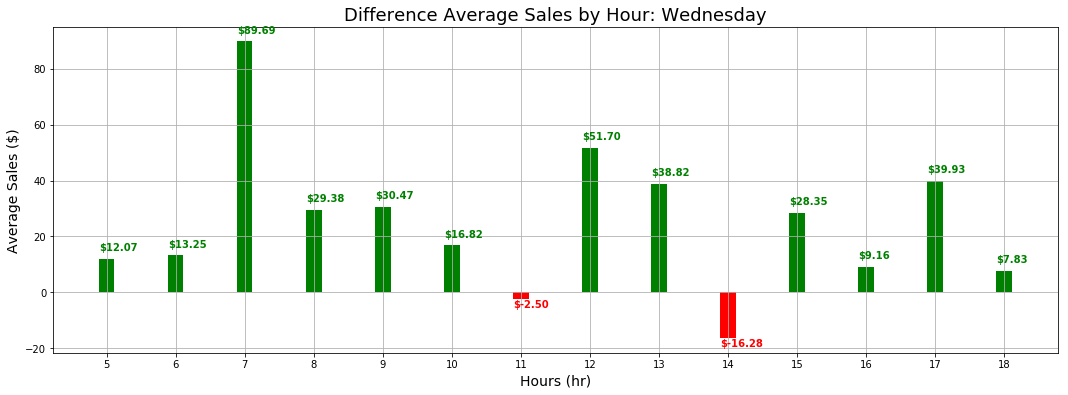

Year Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,12.35,17.47,14.09,14.84,13.93,0,0
6,50.84,63.96,61.12,61.47,62.40,0.62,0.07
7,130.50,137.34,153.05,153.65,166.23,38.76,7.19
8,110.53,120.30,123.79,121.94,139.98,73.83,44.00
9,101.14,102.09,105.84,102.81,103.69,77.80,67.21
10,84.69,92.95,94.34,92.08,106.96,85.95,77.98
11,47.38,59.26,44.75,46.85,56.89,66.30,60.89
12,50.13,54.60,53.38,54.01,52.09,53.73,42.32
13,41.41,44.11,43.27,43.77,55.44,38.72,32.33


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,730.06,808.49,801.47,809.34,884.58,522.12,378.48


Week Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,36.19,32.15,26.16,18.83,25.71,0,0
6,97.38,78.24,74.37,111.79,90.61,0,0
7,192.29,183.45,242.74,272.16,318.61,84.48,14.00
8,136.93,126.58,153.17,124.89,209.35,87.68,52.82
9,128.22,124.82,136.31,156.32,104.20,88.57,101.20
10,107.15,82.65,111.16,98.40,124.98,67.47,162.07
11,53.03,61.28,42.25,37.41,49.48,39.71,58.33
12,82.78,57.77,105.08,74.38,116.36,0,22.03
13,32.83,62.09,82.09,52.34,22.03,0,50.27


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,1020.99,1001.11,1149.96,1147.72,1061.33,367.91,525.89


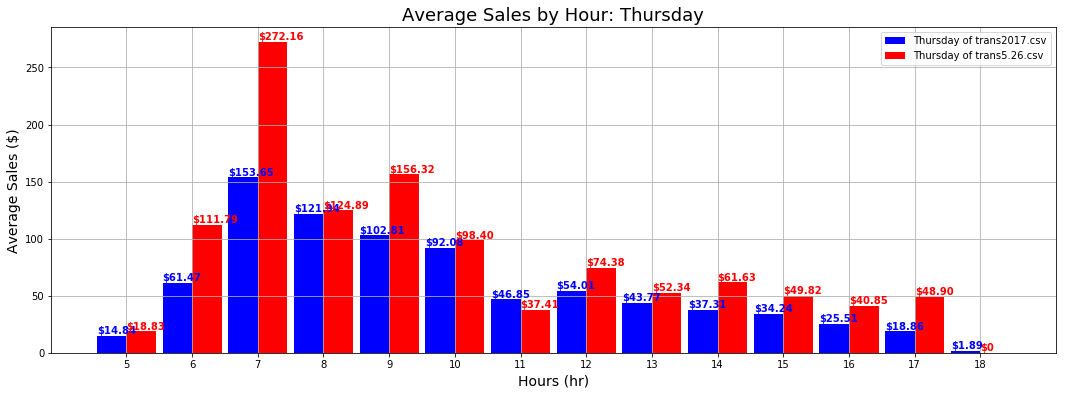

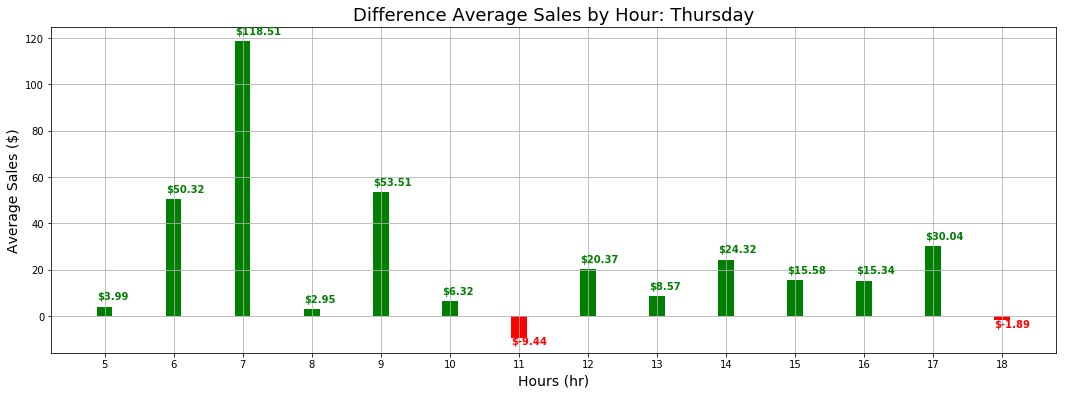

Year Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,12.35,17.47,14.09,14.84,13.93,0,0
6,50.84,63.96,61.12,61.47,62.40,0.62,0.07
7,130.50,137.34,153.05,153.65,166.23,38.76,7.19
8,110.53,120.30,123.79,121.94,139.98,73.83,44.00
9,101.14,102.09,105.84,102.81,103.69,77.80,67.21
10,84.69,92.95,94.34,92.08,106.96,85.95,77.98
11,47.38,59.26,44.75,46.85,56.89,66.30,60.89
12,50.13,54.60,53.38,54.01,52.09,53.73,42.32
13,41.41,44.11,43.27,43.77,55.44,38.72,32.33


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,730.06,808.49,801.47,809.34,884.58,522.12,378.48


Week Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,36.19,32.15,26.16,18.83,25.71,0,0
6,97.38,78.24,74.37,111.79,90.61,0,0
7,192.29,183.45,242.74,272.16,318.61,84.48,14.00
8,136.93,126.58,153.17,124.89,209.35,87.68,52.82
9,128.22,124.82,136.31,156.32,104.20,88.57,101.20
10,107.15,82.65,111.16,98.40,124.98,67.47,162.07
11,53.03,61.28,42.25,37.41,49.48,39.71,58.33
12,82.78,57.77,105.08,74.38,116.36,0,22.03
13,32.83,62.09,82.09,52.34,22.03,0,50.27


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,1020.99,1001.11,1149.96,1147.72,1061.33,367.91,525.89


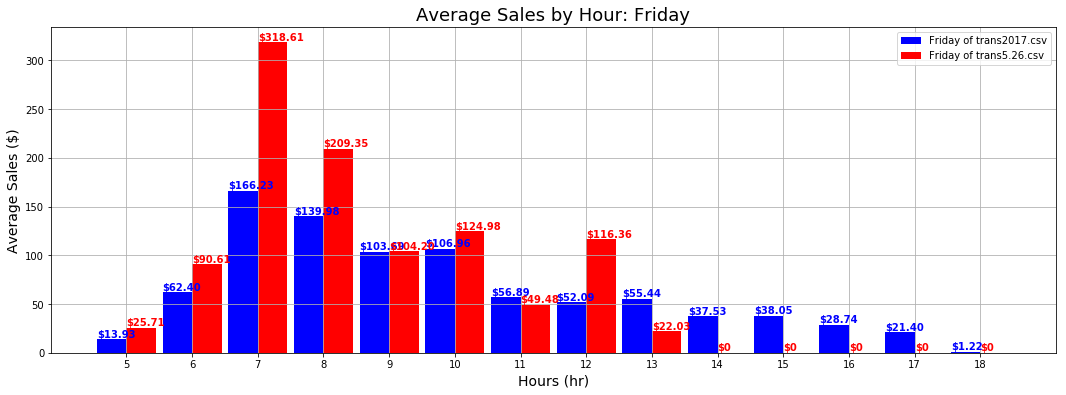

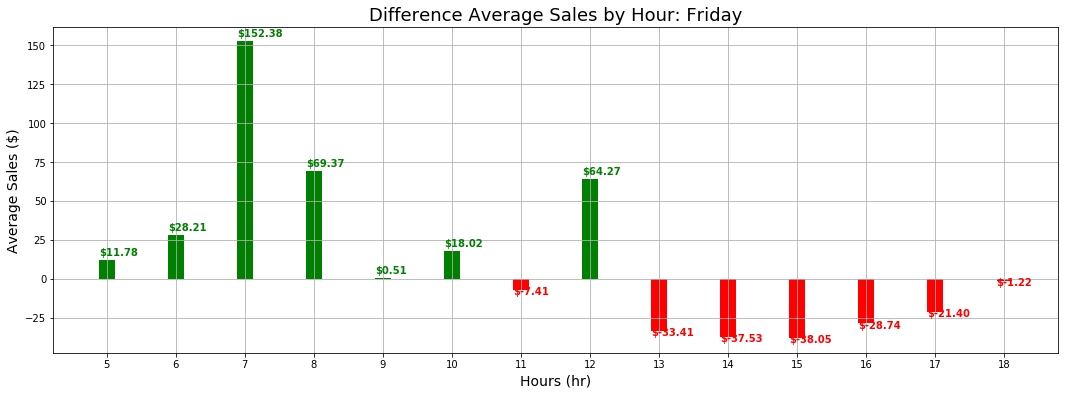

Year Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,12.35,17.47,14.09,14.84,13.93,0,0
6,50.84,63.96,61.12,61.47,62.40,0.62,0.07
7,130.50,137.34,153.05,153.65,166.23,38.76,7.19
8,110.53,120.30,123.79,121.94,139.98,73.83,44.00
9,101.14,102.09,105.84,102.81,103.69,77.80,67.21
10,84.69,92.95,94.34,92.08,106.96,85.95,77.98
11,47.38,59.26,44.75,46.85,56.89,66.30,60.89
12,50.13,54.60,53.38,54.01,52.09,53.73,42.32
13,41.41,44.11,43.27,43.77,55.44,38.72,32.33


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,730.06,808.49,801.47,809.34,884.58,522.12,378.48


Week Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,36.19,32.15,26.16,18.83,25.71,0,0
6,97.38,78.24,74.37,111.79,90.61,0,0
7,192.29,183.45,242.74,272.16,318.61,84.48,14.00
8,136.93,126.58,153.17,124.89,209.35,87.68,52.82
9,128.22,124.82,136.31,156.32,104.20,88.57,101.20
10,107.15,82.65,111.16,98.40,124.98,67.47,162.07
11,53.03,61.28,42.25,37.41,49.48,39.71,58.33
12,82.78,57.77,105.08,74.38,116.36,0,22.03
13,32.83,62.09,82.09,52.34,22.03,0,50.27


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,1020.99,1001.11,1149.96,1147.72,1061.33,367.91,525.89


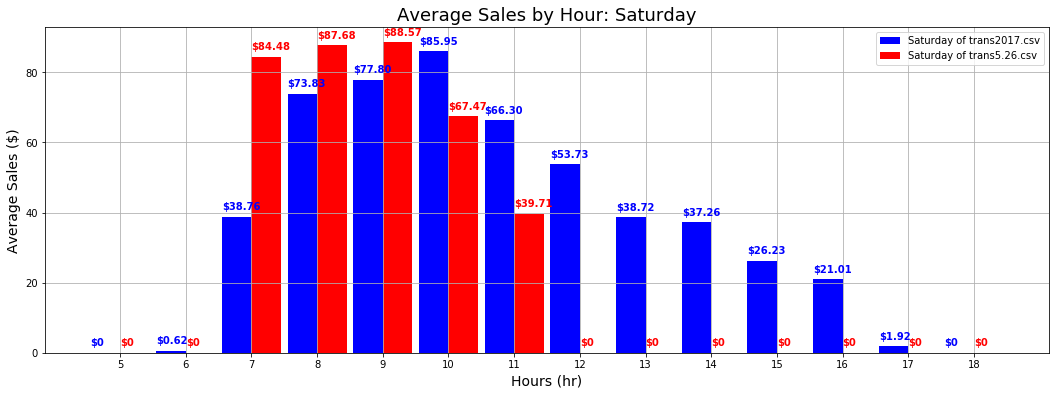

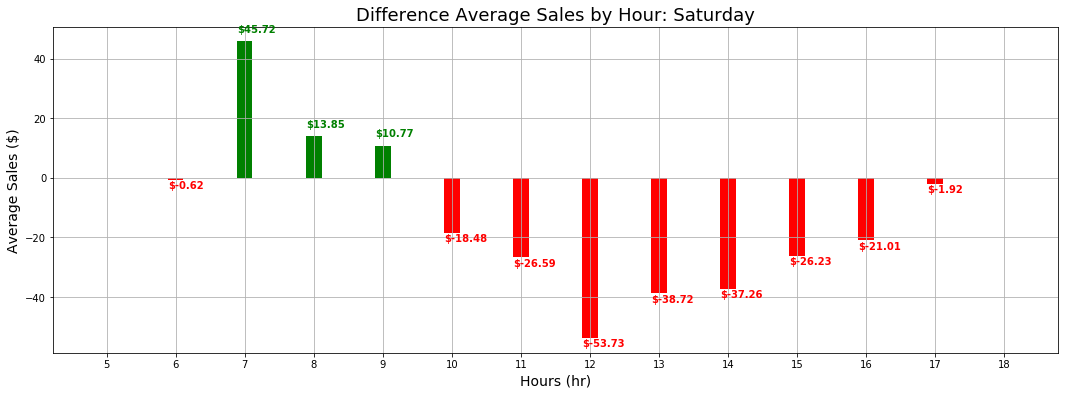

Year Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,12.35,17.47,14.09,14.84,13.93,0,0
6,50.84,63.96,61.12,61.47,62.40,0.62,0.07
7,130.50,137.34,153.05,153.65,166.23,38.76,7.19
8,110.53,120.30,123.79,121.94,139.98,73.83,44.00
9,101.14,102.09,105.84,102.81,103.69,77.80,67.21
10,84.69,92.95,94.34,92.08,106.96,85.95,77.98
11,47.38,59.26,44.75,46.85,56.89,66.30,60.89
12,50.13,54.60,53.38,54.01,52.09,53.73,42.32
13,41.41,44.11,43.27,43.77,55.44,38.72,32.33


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,730.06,808.49,801.47,809.34,884.58,522.12,378.48


Week Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,36.19,32.15,26.16,18.83,25.71,0,0
6,97.38,78.24,74.37,111.79,90.61,0,0
7,192.29,183.45,242.74,272.16,318.61,84.48,14.00
8,136.93,126.58,153.17,124.89,209.35,87.68,52.82
9,128.22,124.82,136.31,156.32,104.20,88.57,101.20
10,107.15,82.65,111.16,98.40,124.98,67.47,162.07
11,53.03,61.28,42.25,37.41,49.48,39.71,58.33
12,82.78,57.77,105.08,74.38,116.36,0,22.03
13,32.83,62.09,82.09,52.34,22.03,0,50.27


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,1020.99,1001.11,1149.96,1147.72,1061.33,367.91,525.89


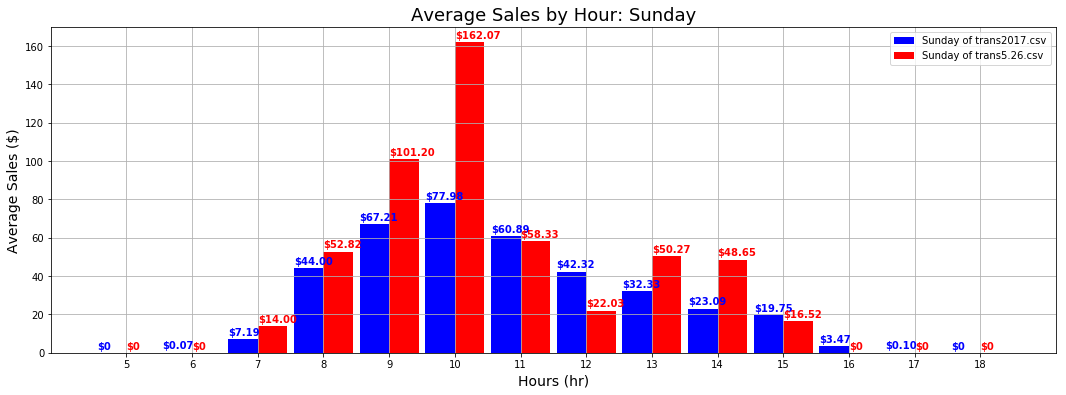

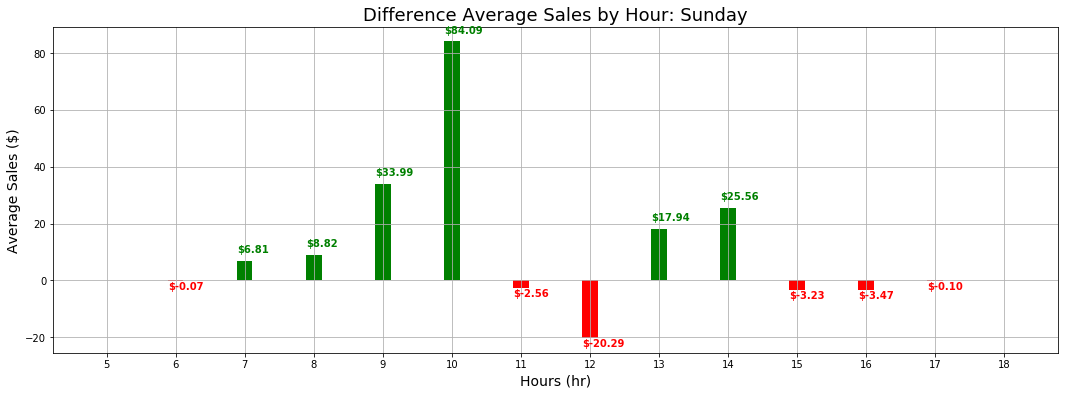

Year Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,12.35,17.47,14.09,14.84,13.93,0,0
6,50.84,63.96,61.12,61.47,62.40,0.62,0.07
7,130.50,137.34,153.05,153.65,166.23,38.76,7.19
8,110.53,120.30,123.79,121.94,139.98,73.83,44.00
9,101.14,102.09,105.84,102.81,103.69,77.80,67.21
10,84.69,92.95,94.34,92.08,106.96,85.95,77.98
11,47.38,59.26,44.75,46.85,56.89,66.30,60.89
12,50.13,54.60,53.38,54.01,52.09,53.73,42.32
13,41.41,44.11,43.27,43.77,55.44,38.72,32.33


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,730.06,808.49,801.47,809.34,884.58,522.12,378.48


Week Average Sales by Hour


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
5,36.19,32.15,26.16,18.83,25.71,0,0
6,97.38,78.24,74.37,111.79,90.61,0,0
7,192.29,183.45,242.74,272.16,318.61,84.48,14.00
8,136.93,126.58,153.17,124.89,209.35,87.68,52.82
9,128.22,124.82,136.31,156.32,104.20,88.57,101.20
10,107.15,82.65,111.16,98.40,124.98,67.47,162.07
11,53.03,61.28,42.25,37.41,49.48,39.71,58.33
12,82.78,57.77,105.08,74.38,116.36,0,22.03
13,32.83,62.09,82.09,52.34,22.03,0,50.27


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Average Gross Sales,1020.99,1001.11,1149.96,1147.72,1061.33,367.91,525.89


In [36]:
#process transactions
yr= process_transactions(path1)
wk= process_transactions(path2)

#run all 7 days of the week
for i,k in days_key.items():
    plot_sales(yr, wk, k, show_frames = True, save = True) 